<a href="https://colab.research.google.com/github/vidyadhawal/Cycle_Hiring_count_prediction_Time_Series_Forecasting/blob/master/Cycle_hiring_count_prediction_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Liabraries for time series forecasting**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from math import sqrt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,median_absolute_error,mean_squared_log_error

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

In [3]:
pip install pyramid.arima

     |████████████████████████████████| 604kB 5.0MB/s 


#**Importing Data**
Dataset: Cycle hiring count prediction

In [5]:
from google.colab import files
uploaded=files.upload()

Saving Avg_Monthly_Cycle_Hiring_Count.csv to Avg_Monthly_Cycle_Hiring_Count.csv


In [6]:
data=pd.read_csv('Avg_Monthly_Cycle_Hiring_Count.csv')
data.head()

,Year_Month,Cycle_Hiring_Count
0,2001-01,648
1,2001-02,646
2,2001-03,639
3,2001-04,654
4,2001-05,630


In [ ]:
data.shape

(114, 2)

In [ ]:
data.describe()

,Cycle_Hiring_Count
count,114.000000
mean,1120.543860
std,270.888317
min,613.000000
25%,885.000000
50%,1158.000000
75%,1340.000000
max,1558.000000


In [ ]:
data.describe(include='O')

,Year_Month
count,114
unique,114
top,2002-01
freq,1


In [ ]:
print('Time period start: {} \nTime period end: {}'.format(data['Year_Month'].min(),data['Year_Month'].max()))

Time period start: 2001-01 
Time period end: 2010-06


#**Data Preprocessing and visualization**

**Converting to Datetime format**

In [7]:
data['Year_Month']=pd.to_datetime(data['Year_Month'],format='%Y-%m')

In [ ]:
data.head()

,Year_Month,Cycle_Hiring_Count
0,2001-01-01,648
1,2001-02-01,646
2,2001-03-01,639
3,2001-04-01,654
4,2001-05-01,630


**setting year_month as index**

In [8]:
data=data.set_index('Year_Month')

In [ ]:
data.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01'],
              dtype='datetime64[ns]', name='Year_Month', length=114, freq=None)

**Checking for null values**

In [ ]:
data.isnull().sum()

Cycle_Hiring_Count    0
dtype: int64

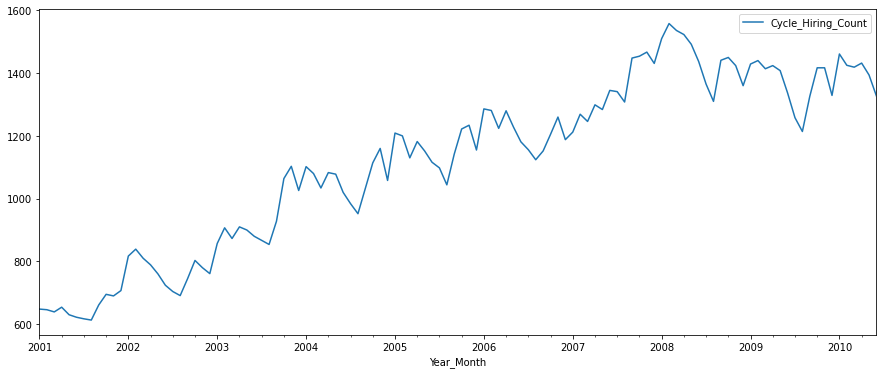

In [ ]:
data.plot(figsize=(15,6))

**Reviewing plots of the density of observations can provide further insight into the structure of data:**


*   The distribution is not perfectly guassian
*   The distribution is left shifted
*   Transforamtion might be useful prior to medelling

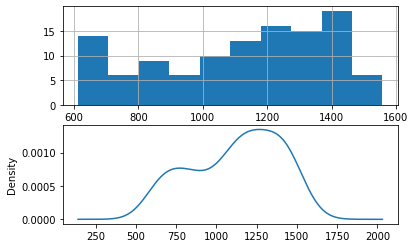

In [ ]:
plt.figure(1)
plt.subplot(211)
data.Cycle_Hiring_Count.hist()
plt.subplot(212)
data.Cycle_Hiring_Count.plot(kind='kde')

**Decomposing using Statsmodel**

*   we can use statsmodel to perform a decomposition of this time series
*   The decomposition of time series is statistical task that deconstructs a time series into several components, each repersenting one of the underlying categories of patterns.
*  with statsmodel we will be able to see the trend,seasonal,and residual components of our data.

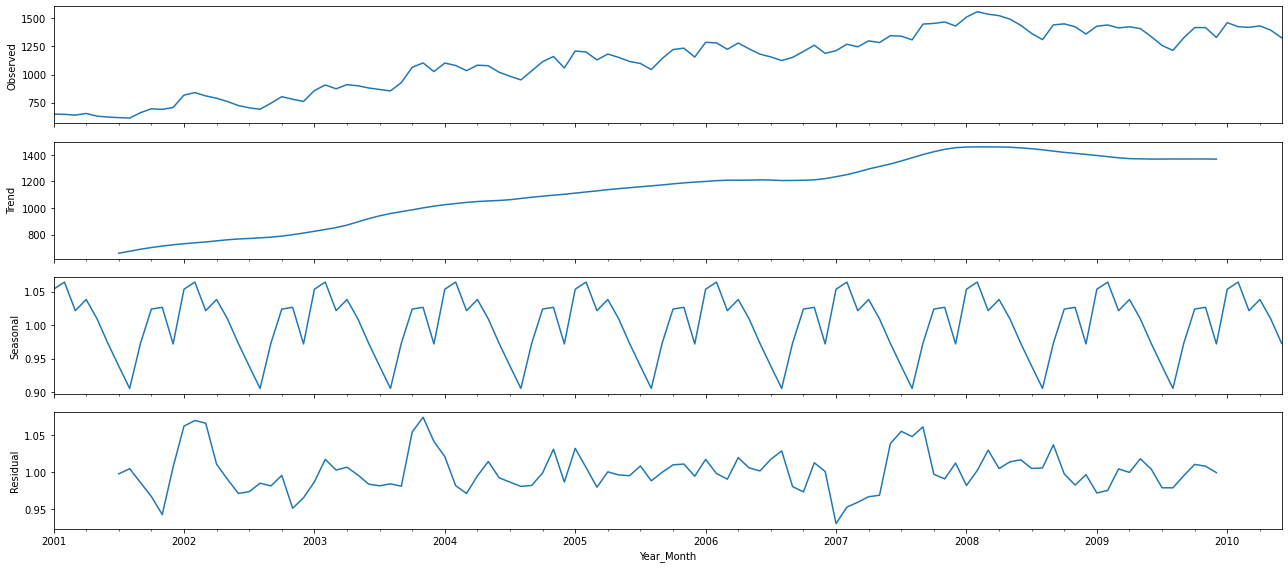

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition=sm.tsa.seasonal_decompose(data,model='multiplicative')
fig=decomposition.plot()
plt.show()


#**Stationarity**

*   A time series is said to be stationary if its statistical properties such as mean,variance remain constant over time
*   Most of the time series model work on the assumption that the TS is stationary.
*  Intutively, we can say that if a time series has particular behavior over time there is a very high probability that it will follow the same in future.

**we can check the stationary using the following:**

*   **ACF and PACF plots:** If the time series is stationary ACF/PACF plots will show a quick drop-off in corealtion after a small amount of lag between points.
*   **Plotting Rolling Statistics:** we can plot the moving average or moving variance and see if it varies with time
*   **Augmented Dickey-Fuller Test:** This is one of the statistical test for checking stationarity. Here the null hypothesis is that the TS is non stationary. The test results comprise of test statistics and some critical value for difference confidance level . If the 'test statistics is less than the 'Critical value' we can reject the null hypothesis and say that TS is stationary.

#ACF and PACF plots

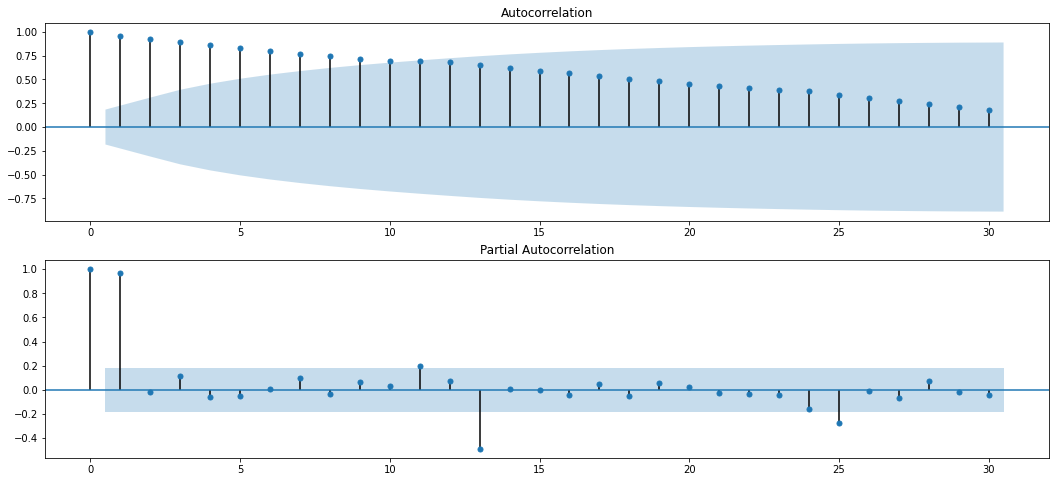

In [12]:
plt.figure()
plt.subplot(211)
plot_acf(data.Cycle_Hiring_Count,ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(data.Cycle_Hiring_Count,ax=plt.gca(),lags=30)
plt.show()

*   This data is non stationary as a high number of previous observations are corelated with future values 
*   Confidance interval are drawn as a cone
*   By default this is set to be 95% confidance interval, suggesting that corelation values outside of this code are very likely a corelation and not a statistical fluke

#Plotting Rolling statistics

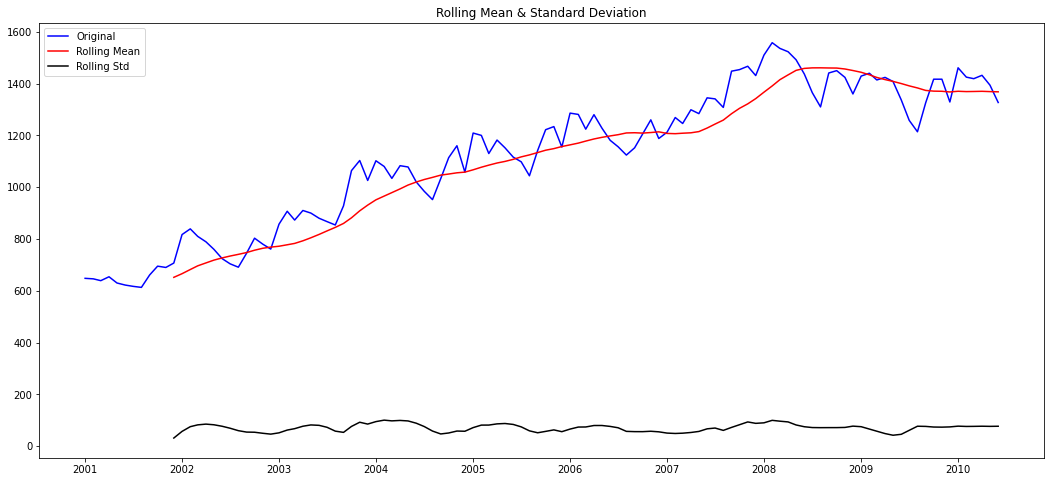

In [13]:

#Determing rolling statistics
rolmean = data.rolling(window=12).mean()
rolstd = data.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

#Augmented Dickey fuller test

In [14]:
#perform Dickey fuller test
print('Result of Dickey fuller test:')
dftest=adfuller(data.Cycle_Hiring_Count,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#lags used','Number of observations used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value(%s)'%key]=value
print(dfoutput)

Result of Dickey fuller test:
Test Statistics                 -1.536597
p-value                          0.515336
#lags used                      12.000000
Number of observations used    101.000000
Critical Value(1%)              -3.496818
Critical Value(5%)              -2.890611
Critical Value(10%)             -2.582277
dtype: float64


In [23]:
def test_statinarity(timeseries):
  #Determing rolling statistics
  rolmean=timeseries.rolling(window=12).mean()
  rolstd=timeseries.rolling(window=12).std()

  #Plot rolling statistics
  orig=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rolmean,color='red',label='Rolling Mean')
  std=plt.plot(rolstd,color='black',label='Rolling std')
  plt.legend()
  plt.title('Rolling mean & Standard deviation')

  #Perform Dickey-Fuller test
  print('Results of Dickey-Fuller Test:')
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lag used','Number of observations used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key]=value
  print(dfoutput)

#**Making Time Series Statinary**
There are 2 major reasons behind non-stationary of a TS
1.   **Trend**-varying mean over time. for eg in this case we saw that on average cycling hours are growing over time.
2.   **Seasonality**-variations at specific time frmaes eg peples might take cycles for riding in particular months because of environmental conditions.



#**Transformations**
.   we can apply transformation which penalize higher values more than smaller values.These can be done by taking a log, square root,cube rootetc.Lets take a log transform here for simplicity

**Log Scale Transformation**

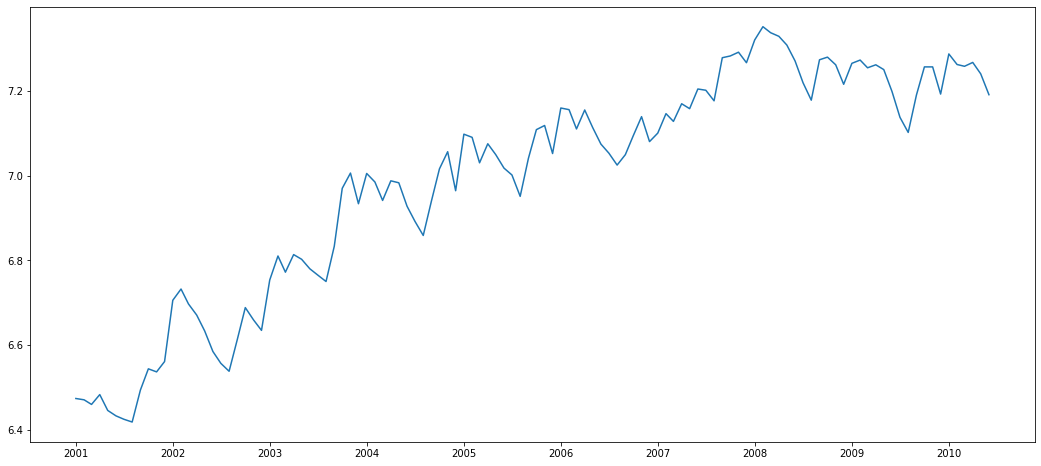

In [15]:
ts_log=np.log(data)
plt.plot(ts_log)

**Other possible transformation**

*   Exponential Transformation
*   Box Cox transformation
*   Square root transformation

#**Technique to remove trend-Smoothing**
*   Smoothing is taking rolling average over windows of time

**Moving Average**
*   we take average of 'k' consecutive values depending on frequency of Time Series
*   Here we can take the average over the past 1 year, i.e last 12 values
*   A drawback in this particular approach is the time-period has to strictly defined.

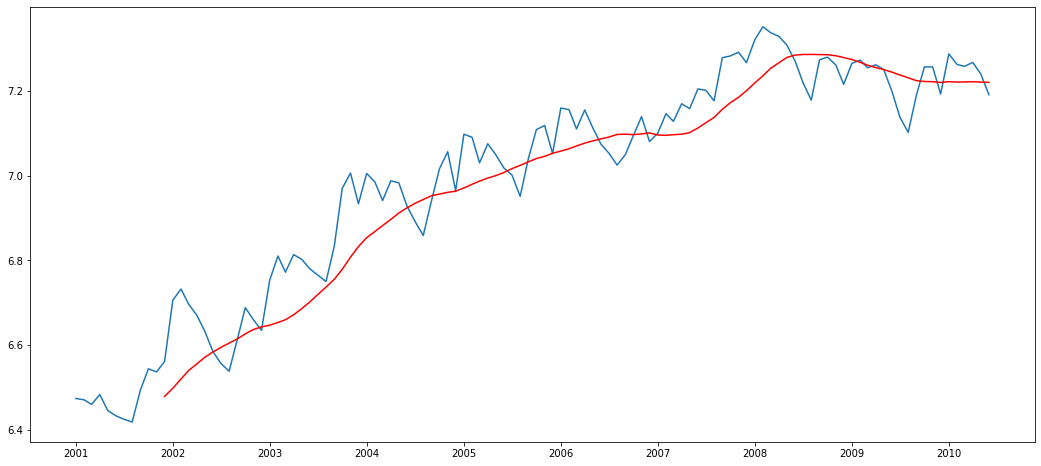

In [17]:
moving_avg=ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color='red')

In [18]:
ts_log_moving_avg_diff=ts_log.Cycle_Hiring_Count-moving_avg.Cycle_Hiring_Count
ts_log_moving_avg_diff.head()

Year_Month
2001-01-01   NaN
2001-02-01   NaN
2001-03-01   NaN
2001-04-01   NaN
2001-05-01   NaN
Name: Cycle_Hiring_Count, dtype: float64

Results of Dickey-Fuller Test:
Test Statistics                -2.579211
p-value                         0.097371
#Lag used                      12.000000
Number of observations used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


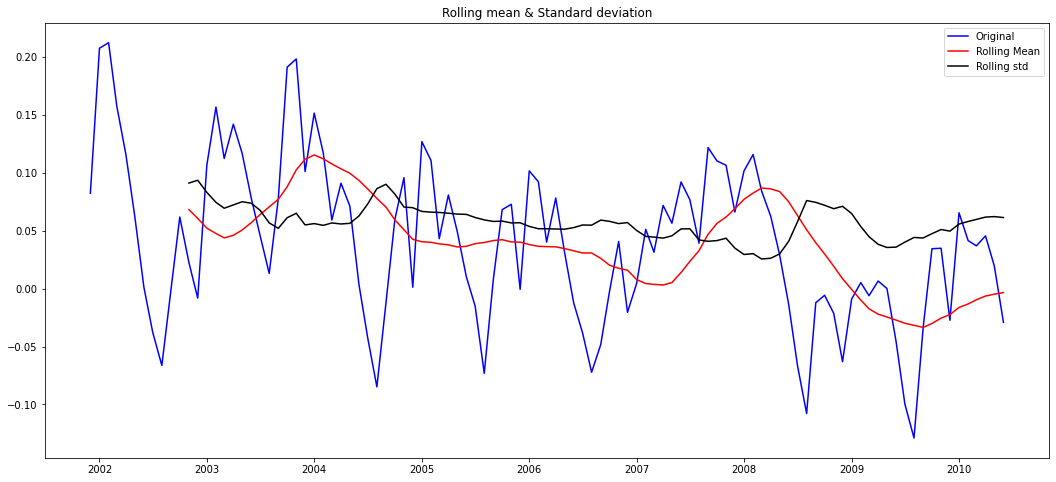

In [24]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_statinarity(ts_log_moving_avg_diff)

**Differencing:**
*   In this technique we take the difference of the observations at a particular instant with that at the previous instant

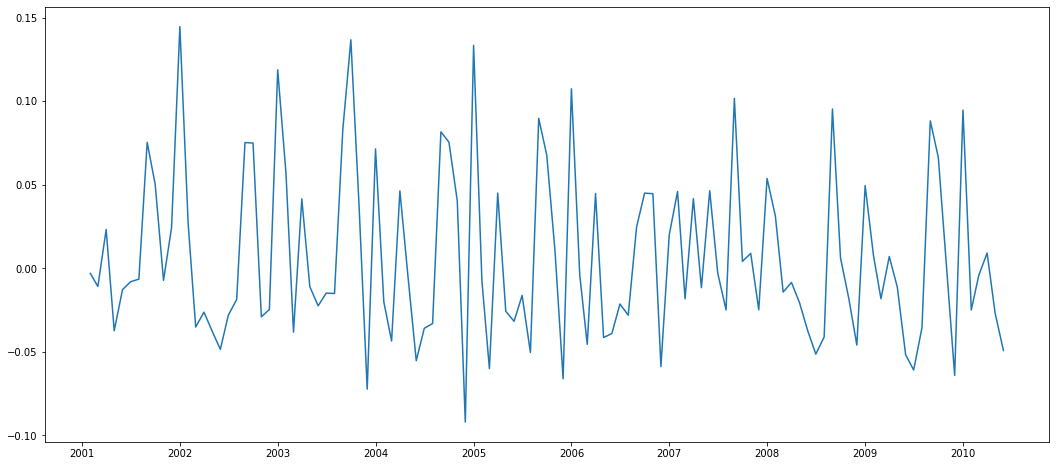

In [27]:
ts_log_diff=ts_log.Cycle_Hiring_Count-ts_log.Cycle_Hiring_Count.shift()
plt.plot(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistics                 -2.047539
p-value                          0.266126
#Lag used                       11.000000
Number of observations used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


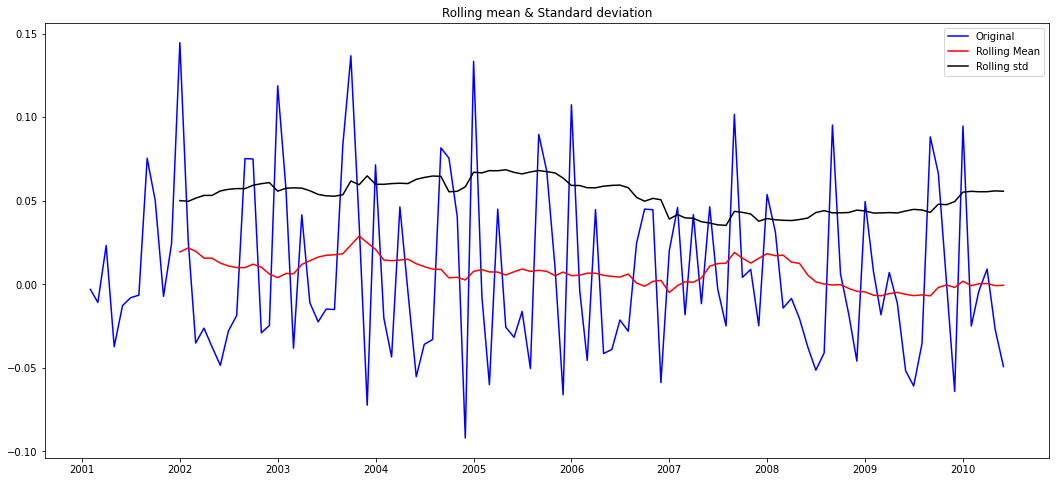

In [28]:
ts_log_diff.dropna(inplace=True)
test_statinarity(ts_log_diff)

**Decomposition**
*   In this approach both trend and seasonality are modeled seperaroly and the remaining part of the series is returned

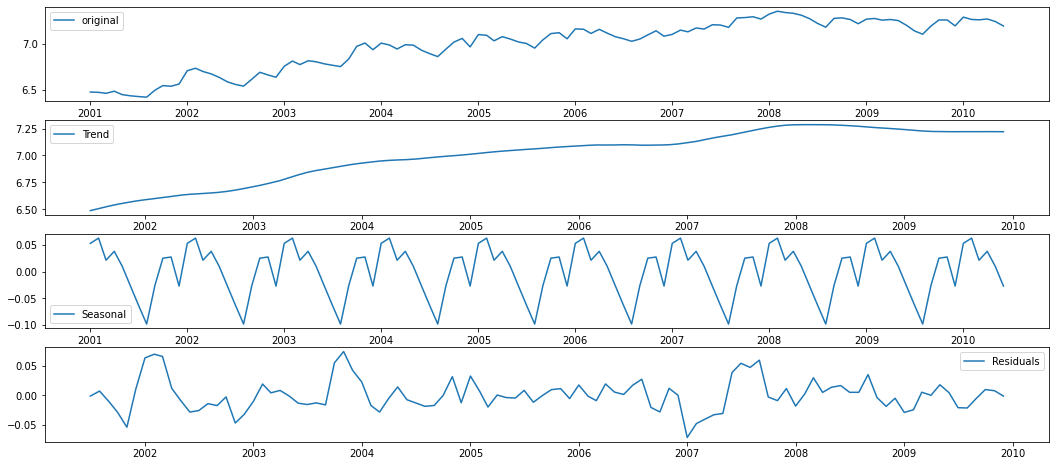

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(ts_log)

trend=decomposition.trend
seasonal=decomposition.seasonal
residul=decomposition.resid

plt.subplot(411)
plt.plot(ts_log,label='original')
plt.legend()
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(residul,label='Residuals')
plt.legend()

Results of Dickey-Fuller Test:
Test Statistics               -6.370421e+00
p-value                        2.352564e-08
#Lag used                      3.000000e+00
Number of observations used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64


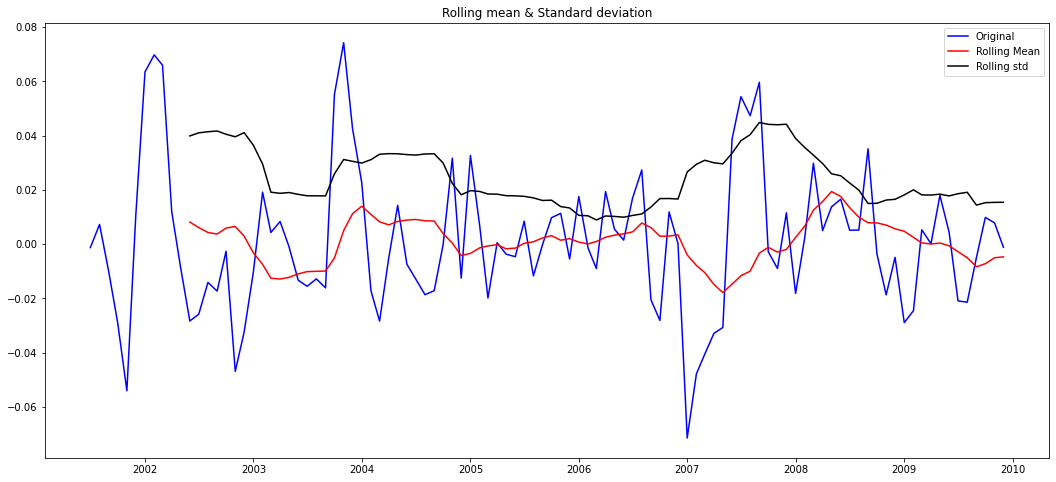

In [30]:
ts_log_decompose=residul.Cycle_Hiring_Count
ts_log_decompose.dropna(inplace=True)
test_statinarity(ts_log_decompose)

#**Autoregressive Integrated Moving Average**
In ARIMA there are 3 parameters that are used to help model the major aspect of a time series : seasonality,trend and noise. These parameters are labeled as p,d,q
*   **Number of AR(Auto-Regression) terms p:**-p is the parameter associated with the auto-regressive aspectof the modelwhich incorporates past values i.e lags of dependent variable 
*   **Number of Differences(d):**-d is the parameter associated with integrated part of the model, which effects the amount of differencing to apply to a time series 
*   **Number of MA(Moving Average) terms (q)**- q is the size of the moving average part window of the model i.e lagged forecast errors in prediction equationfor instance if q=5 the predictors for x(t) will be e(t-1).....e(t-5) where e(i) is the difference between the moving average at ith instant and actual value

A problem with ARIMA is that it does not support seasonal data. That is the time series with with a repeting cycle.ARIMA expects that data is either not seasonal or has the seasonal component removed. e.g seasonally adjusted via methods seasonal differencing

In [31]:
ts=data.Cycle_Hiring_Count-data.Cycle_Hiring_Count.shift()
ts.dropna(inplace=True)

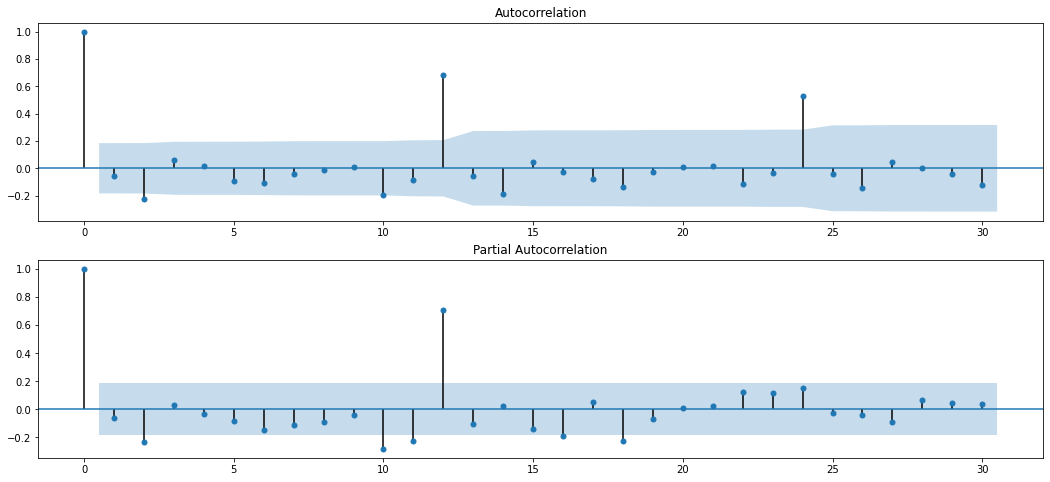

In [32]:
plt.figure()
plt.subplot(211)
plot_acf(ts,ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(ts,ax=plt.gca(),lags=30)
plt.show()

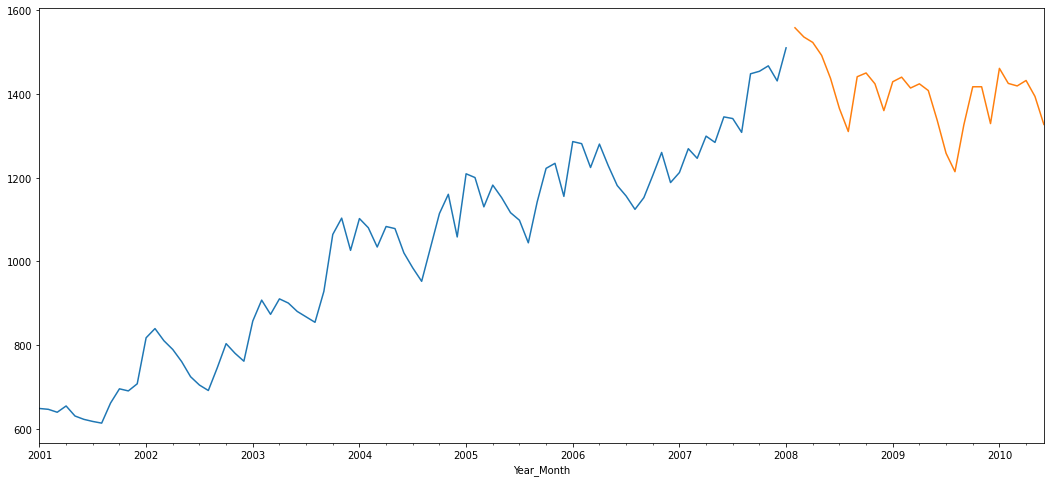

In [33]:
#Divide into train and validation set
train=data[:int(0.75*(len(data)))]
valid=data[int(0.75*(len(data))):]

#Plotting the data
train['Cycle_Hiring_Count'].plot()
valid['Cycle_Hiring_Count'].plot()

In [35]:
#ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

#fit model
model=ARIMA(train,order=(1,1,1))
model_fit=model.fit(disp=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.Cycle_Hiring_Count   No. Observations:                   84
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -449.138
Method:                         css-mle   S.D. of innovations             49.966
Date:                  Mon, 13 Jul 2020   AIC                            906.276
Time:                          08:50:37   BIC                            916.000
Sample:                      02-01-2001   HQIC                           910.185
                           - 01-01-2008                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          9.5735      0.667     14.363      0.000       8.267      10.880
ar.L1.D.Cycle_Hiring_Count     0.6927      0.083      8.358      0.000       0.530       0.855
ma.L1.D.Cycle_Hiring_Count    -1.0000      0.035    -28.453      0.000      -1.069      -0.931
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4436           +0.0000j            1.4436            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
start_index=valid.index.min()
end_index=valid.index.max()

#predictions
predictions=model_fit.predict(start=start_index,end=end_index)

In [38]:
#report performance
mse=mean_squared_error(data[start_index:end_index],predictions)
rmse=sqrt(mse)
print('RMSE: {},MSE: {}'.format(rmse,mse))

RMSE: 1401.380540259456,MSE: 1963867.4186178846


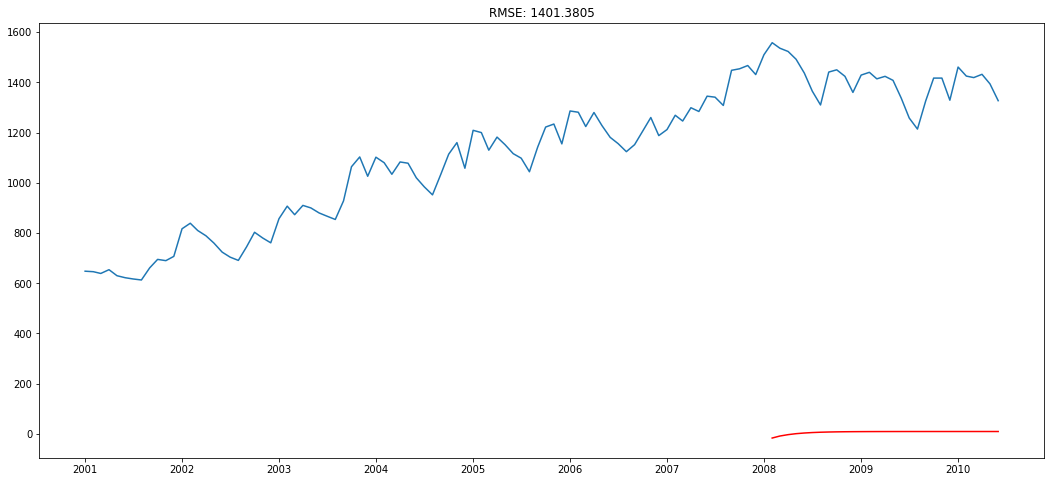

In [39]:
plt.plot(data.Cycle_Hiring_Count)
plt.plot(predictions,color='red')
plt.title('RMSE: %.4f'%rmse)
plt.show()

**Predicted values:**

In [40]:
predictions_ARIMA_diff=pd.Series(predictions,copy=True)
print(predictions_ARIMA_diff.head())

2008-02-01   -16.409540
2008-03-01    -8.425711
2008-04-01    -2.895077
2008-05-01     0.936156
2008-06-01     3.590165
Freq: MS, dtype: float64


**Cumulative sum to reverse Differencing**

In [41]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

2008-02-01   -16.409540
2008-03-01   -24.835251
2008-04-01   -27.730328
2008-05-01   -26.794172
2008-06-01   -23.204007
Freq: MS, dtype: float64


**Adding first month value which was previously removed while differencing**

In [43]:
predictions_ARIMA_log=pd.Series(valid.Cycle_Hiring_Count.iloc[0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2001-01-01    1558.0
2001-02-01    1558.0
2001-03-01    1558.0
2001-04-01    1558.0
2001-05-01    1558.0
dtype: float64

**Taking Exponent to reverse Log Transform**

In [44]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

overflow encountered in exp



Text(0.5, 1.0, 'RMSE: 1570.6449')

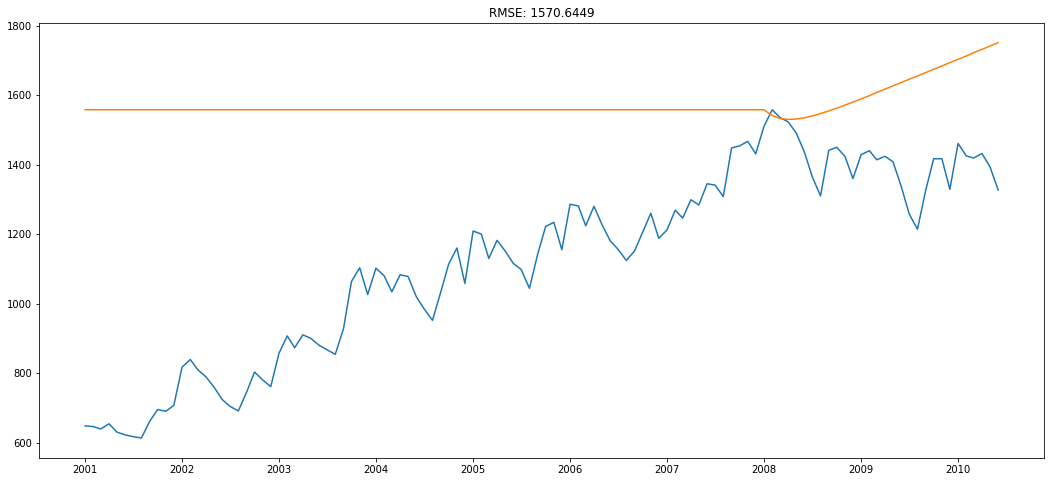

In [51]:
plt.plot(data.Cycle_Hiring_Count)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [56]:
def evaluate_forecast(data,pred):
  results=pd.DataFrame({'r2_score':r2_score(data,pred),},index=[0])
  results['Mean_absolute_error']=mean_absolute_error(data,pred)
  results['Median_absolute_error']=median_absolute_error(data,pred)
  results['mse']=mean_squared_error(data,pred)
  results['rmse']=np.sqrt(results['mse'])
  return results

In [57]:
evaluate_forecast(data[start_index:end_index],predictions)


,r2_score,Mean_absolute_error,Median_absolute_error,mse,rmse
0,-339.339368,1399.100919,1409.429158,1.963867e+06,1401.38054


#**Auto-SARIMA**

In [58]:
#building the model
model=auto_arima(train,trace=True,error_action='ignore',seasonal=True,m=6,stepwise=True)
model.fit(train)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 6); AIC=872.068, BIC=891.515, Fit time=0.966 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=913.593, BIC=918.455, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=914.894, BIC=924.617, Fit time=0.149 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 6); AIC=914.535, BIC=924.258, Fit time=0.135 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 6); AIC=904.950, BIC=921.965, Fit time=0.687 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 6); AIC=856.717, BIC=878.594, Fit time=1.562 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=854.200, BIC=873.647, Fit time=1.262 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=858.979, BIC=875.994, Fit time=0.907 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=856.838, BIC=878.715, Fit time=1.189 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 0, 6); AIC=856.619, BIC=873.635, Fit time=0.627 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 0, 0, 6); AIC=855.465, BIC=877.342, Fit time=1.298 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 0, 6); AIC=857.720, BIC=872.305, Fit time=0.867 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 0, 0, 6); AIC=857.398, BIC=881.707, Fit time=1.450 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 6); AIC=899.537, BIC=916.552, Fit time=0.712 seconds
Total fit time: 11.848 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 6), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

In [59]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [60]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

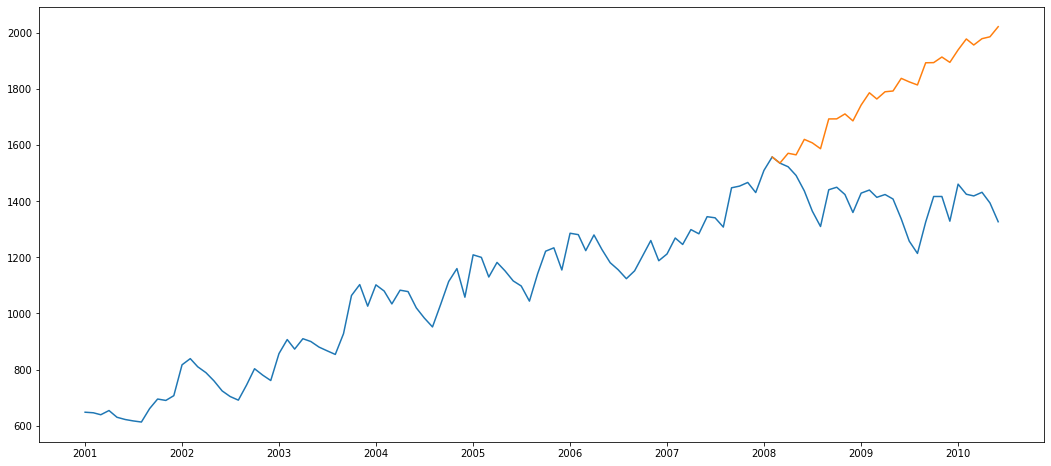

In [61]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(data.Cycle_Hiring_Count, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [62]:
evaluate_forecast(data[start_index:end_index], forecast)

,r2_score,Mean_absolute_error,Median_absolute_error,mse,rmse
0,-29.623825,375.222772,366.320268,176709.303464,420.368057
